# Home Assignment 3 – Explainable AI
## 3945 – Advanced Machine Learning, Spring 2023

# Imports and Set-Up



In [ ]:
import os

In [ ]:
!pip install opendatasets

In [ ]:
import pandas as pd
import numpy as np
import math
import warnings
import tqdm
import random

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.transform import resize


from IPython.display import display
from torchvision.io import ImageReadMode, read_image


import skimage.io
import skimage.segmentation
import copy
import cv2

import gdown
import opendatasets as od
import urllib

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download Images

In [ ]:
od.download(
  "https://drive.google.com/file/d/1SqW97iauy9BWcrr63N4Su036dwD76HGF/view?usp=sharing",)
od.download(
  "https://drive.google.com/file/d/1Pgn_3LDrxGQQpuqbQ2EwFUSGHmc0xZwN/view?usp=sharing",)
od.download(
  "https://drive.google.com/file/d/1a3lzgUbBb1Lq3DLgaYwoD6cBMHnfFHTw/view?usp=sharing")

173159it [00:00, 53655547.16it/s]


Downloaded to  ./frog.png


174909it [00:00, 162449406.19it/s]


Downloaded to  ./kitten.png


7076it [00:00, 5263148.63it/s]

Downloaded to  ./puppy.jpeg


In [ ]:
current_folder = os.path.basename(os.getcwd())

In [ ]:
image_paths = [
  os.path.join("./", "cat", f"/{current_folder}/kitten.png"),
  os.path.join("./", "dog", f"/{current_folder}/puppy.jpeg"),
  os.path.join("./", "frog", f"/{current_folder}/frog.png")
]

# Create Class

In [ ]:
class ImageClassifier:
  def __init__(self, device=device, segments = 100, p=.5, deactivate=25, sigma=10**3, perturbations = 200, alpha = 0.01):
    self.weights = ResNet50_Weights.DEFAULT
    self.category_names = self.weights.meta["categories"]
    self.model = resnet50(weights=self.weights)
    self.transform = self.weights.transforms(antialias=True)
    self.device = device
    self.image_tensor = None
    self.class_values = None
    self.class_indices = None
    self.class_scores = None
    self.scores = []
    self.image = None
    self.segments = segments
    self.segmented_image = None
    self.p=p
    self.deactivate = deactivate
    self.sigma = sigma
    self.perturbations = perturbations
    self.df = pd.DataFrame()
    self.image_segments = None
    self.alpha=alpha
    self.label = None
    self.output = None
    self.kernel_similarity = None
    self.distance = None
    self.score = None
    self.perturbation_score = None
    self.filtered_data = None
    self.classifier = None
    self.images_dict = {}

  def _convert_image(self):
    self.image = self.image.permute(1,2,0)

  def _process_tensor(self):
    self.image_tensor = self.transform(self.image)
    self.image_tensor = self.image_tensor.to(self.device)
    with torch.no_grad():
      self.output= self.model(self.image_tensor.unsqueeze(0)).cpu()
    self.image_tensor = self.image_tensor.permute(1,2,0)

  def _get_classes(self):
    self.class_values, self.class_indices = torch.topk(self.output, k=3, dim=1)
    self.class_values = self.class_values.squeeze().detach().numpy()
    self.class_indices = self.class_indices.squeeze().detach().numpy()
    self.class_names = np.array(self.category_names)[self.class_indices]
    self.class_scores = list(zip(self.class_names, self.class_values))
    return self.class_scores

  def _display_images(self):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(np.clip(np.asarray(self.image).transpose(1, 2, 0), 0, 255))
    axes[0].axis('off')
    axes[0].set_title(f"Original Image of {self.label}")

    self._convert_image()
    self._segment_image()
    axes[1].imshow(mark_boundaries(self.image.numpy(), self.segmented_image))
    axes[1].axis('off')
    axes[1].set_title(f"{self.label} with superpixel segmentation - {self.segments} superpixels")

    image = self._mask()
    axes[2].imshow(image)
    axes[2].axis('off')
    axes[2].set_title(f"{self.label} with activated superpixels")

    plt.tight_layout()
    plt.show()

  def _display_class(self):
    num_images = len(self.images_dict)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    fig.tight_layout(pad=3.0)

    for i, (class_name, image) in enumerate(self.images_dict.items()):
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Positive superpixels for {class_name}")
    plt.show()

  def _segment_image(self):
    self.segmented_image = slic(self.image, n_segments=self.segments, compactness=10, max_num_iter=30, enforce_connectivity=True, start_label=0)

  def _super_pixels(self):
    return np.random.choice([0, 1], size=self.segmented_image.max() + 1, p=[1 - self.p, self.p])

  def _mask(self):
    image = self.image.numpy().copy()
    image[np.isin(self.segmented_image, np.unique(self.segmented_image)[self._super_pixels() == 0])] = [128, 128, 128]
    return image

  def model_predict_score_classification(self, img, target_class_id):
    img = img.permute(2, 1, 0).to(device)
    with torch.no_grad():
        output = self.model(img.unsqueeze(0).float())
    return output[0][target_class_id].item()

  def _deactivations(self):
    return np.random.choice(range(self.segments), self.deactivate, replace=False)

  def _create_interpretable_instance(self, deactivations):
    interpretable_instance = np.ones(self.segments)
    interpretable_instance[deactivations] = 0
    return interpretable_instance

  def _deactivate_segments(self, deactivations):
    return np.isin(self.segmented_image, deactivations)

  def _create_perturbed_image(self, deactivations):
    image = self.image_tensor.clone()
    image[self._deactivate_segments(deactivations)] = 0
    return image

  def _calculate_distance(self, deactivated_image):
    return torch.dist(self.image_tensor.float(), deactivated_image.float()).item()

  def _calculate_kernel_similarity(self):
    return np.exp(-1 * (self.distance ** 2) / (self.sigma ** 2))

  def _calculate_loss(self):
    return (self.kernel_similarity * (self.score - self.perturbation_score) ** 2).item()

  def _get_active_pixels(self):
    superpixels = np.zeros(self.segments)
    superpixels[np.argwhere(self.classifier.coef_ > 0)] = 1
    return superpixels

  def _fit_linear_model(self):
    self.classifier = linear_model.Lasso(self.alpha, max_iter=1000).fit(self.filtered_data["interpretable_instance"].to_list(),
            self.filtered_data["perturbation_score"].to_list(), self.filtered_data["kernel_similarity"].to_list())

  def initialize(self):
    self.model.eval()
    self.model.to(self.device)

  def get_classes(self, image_path):
    self.image = read_image(image_path, mode=ImageReadMode.RGB)
    self.label = os.path.splitext(os.path.basename(image_path))[0]
    self._process_tensor()
    self._display_images()

    self.scores.append(self._get_classes())
    print("Class scores:")
    for class_name, class_score in self.class_scores:
      print(f"{class_name} {class_score:.3f}")

  def generate_local_dataset(self):
    df, image_segments= [], []
    self.segmented_image = slic(self.image_tensor, n_segments=self.segments, compactness=10, max_num_iter=30, enforce_connectivity=True, start_label=0)
    image_segments.append(self.segmented_image)
    for prediction, score in self.scores[0]:
      self.score = score
      target_class = np.where(np.array(self.weights.meta["categories"]) == prediction)
      for _ in tqdm.tqdm(range(self.perturbations)):
        deactivations = self._deactivations()
        deactivated_image = self._create_perturbed_image(deactivations)
        self.distance = self._calculate_distance(deactivated_image)
        self.kernel_similarity = self._calculate_kernel_similarity()
        self.perturbation_score = self.model_predict_score_classification(deactivated_image, target_class)
        df.append({"class": prediction, "score": self.score, "interpretable_instance": self._create_interpretable_instance(deactivations),
            "kernel_similarity": self.kernel_similarity, "perturbation_score": self.perturbation_score, "loss": self._calculate_loss()})
    self.df = pd.DataFrame(df)
    self.image_segments = image_segments

  def process_image(self):
    image = self.image_tensor.permute(2, 1, 0)
    images_dict = {}
    for prediction in self.df[self.df["class"].isin(self.class_names)]["class"].unique():
        self.filtered_data = self.df[(self.df["class"] == prediction)]
        self._fit_linear_model()
        remaining_pixels = np.isin(self.image_segments[0], np.argwhere(self._get_active_pixels()))
        maked_image = image.clone()
        mask = np.zeros_like(image)
        for channel in range(3):
            mask[channel] = remaining_pixels
        maked_image *= mask
        maked_image = (maked_image - maked_image.min()) / (maked_image.max() - maked_image.min())

        self.images_dict[prediction] = maked_image.permute(2, 1, 0)
    self._display_class()

  def plot_boxplots(self):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    grouped_data = self.df.groupby("class")["perturbation_score"].apply(list).to_dict()
    score_values = list(grouped_data.values())
    axes[0].boxplot(score_values, labels=list(grouped_data.keys()))
    axes[0].set_title("Box Plot of Perturbation Score for Each Class")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Perturbation Score")

    grouped_data = self.df.groupby("class")["loss"].apply(list).to_dict()
    loss_values = list(grouped_data.values())
    axes[1].boxplot(loss_values, labels=list(grouped_data.keys()))
    axes[1].set_title("Box Plot of Loss for Each Class")
    axes[1].set_xlabel("Class")
    axes[1].set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

# Initialize Model

## Image 1

In [ ]:
classifier1 = ImageClassifier()

In [ ]:
classifier1.initialize()

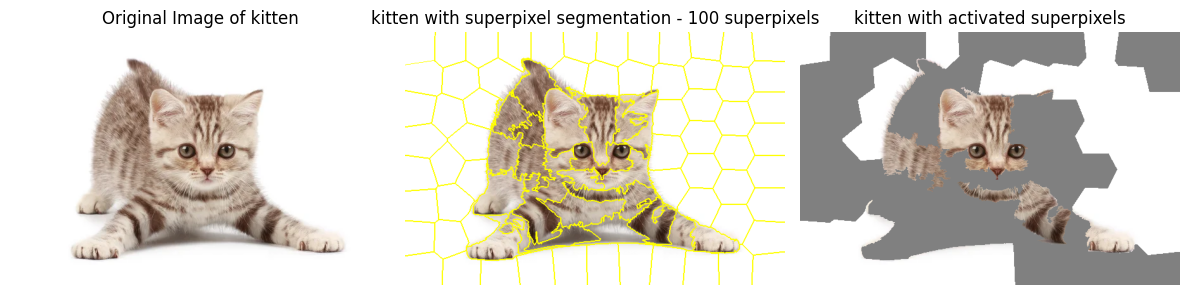

Class scores:
tabby 6.729
Egyptian cat 5.199
tiger cat 4.775


In [ ]:
classifier1.get_classes(image_paths[0])

In [ ]:
classifier1.generate_local_dataset()

100%|██████████| 200/200 [00:39<00:00,  5.12it/s]


In [ ]:
classifier1.df

,class,score,interpretable_instance,kernel_similarity,perturbation_score,loss
0,tabby,6.728618,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.831164,5.657660,0.953303
1,tabby,6.728618,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.884386,5.781893,0.792665
2,tabby,6.728618,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.872676,6.164741,0.277474
3,tabby,6.728618,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.855848,5.550606,1.187670
4,tabby,6.728618,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.856835,5.894624,0.595968
...,...,...,...,...,...,...
595,tiger cat,4.774608,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.896766,3.309653,1.924544
596,tiger cat,4.774608,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.868002,3.276650,1.947691
597,tiger cat,4.774608,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.886273,3.246610,2.069252
598,tiger cat,4.774608,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.875283,3.597157,1.213483


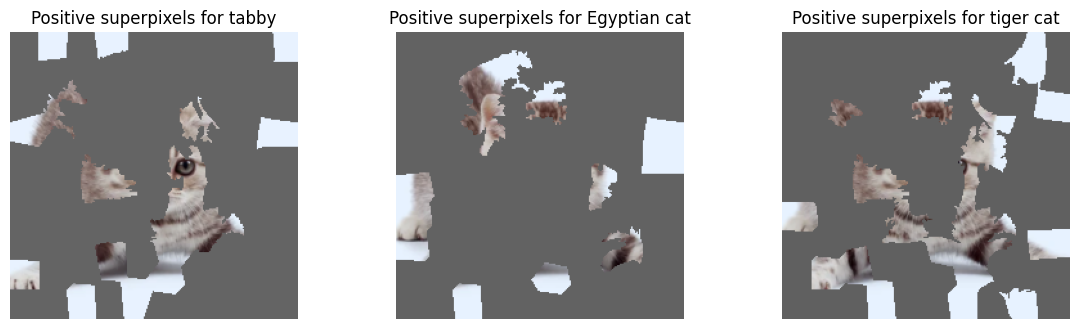

In [ ]:
classifier1.process_image()

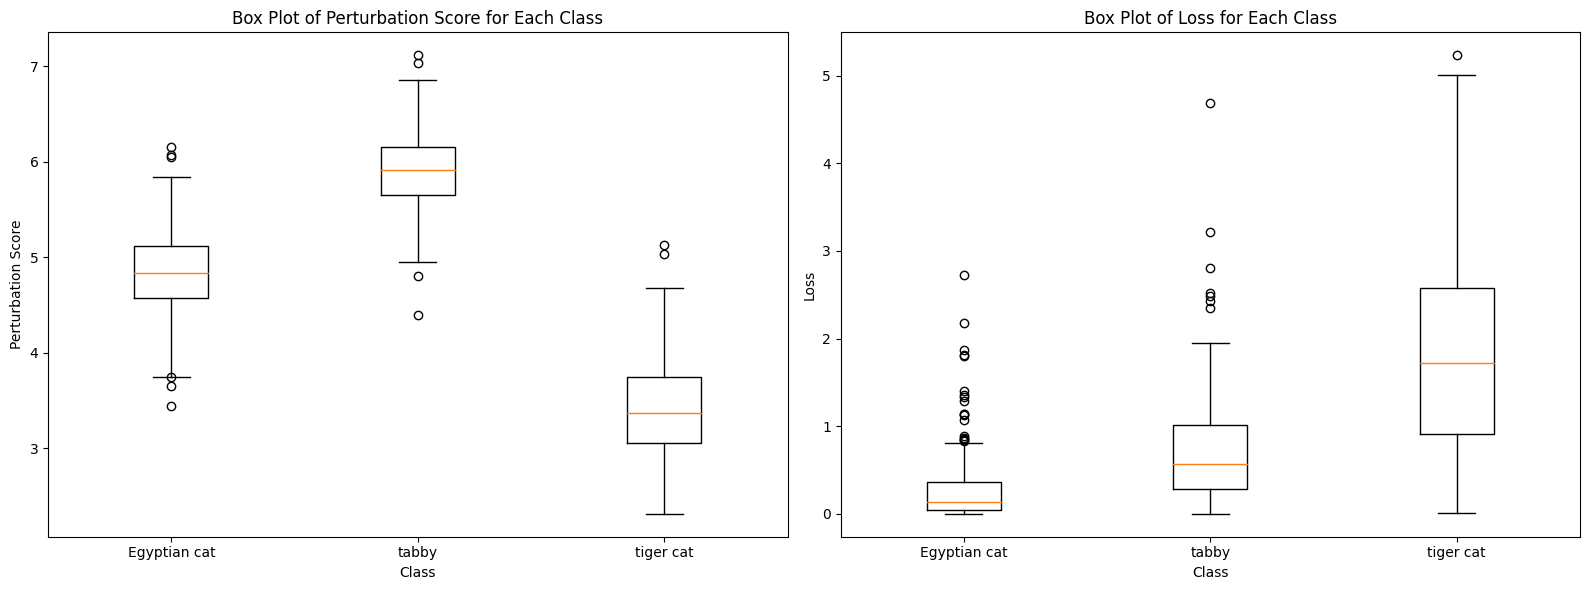

In [ ]:
classifier1.plot_boxplots()

## Image 2

In [ ]:
classifier2 = ImageClassifier()

In [ ]:
classifier2.initialize()

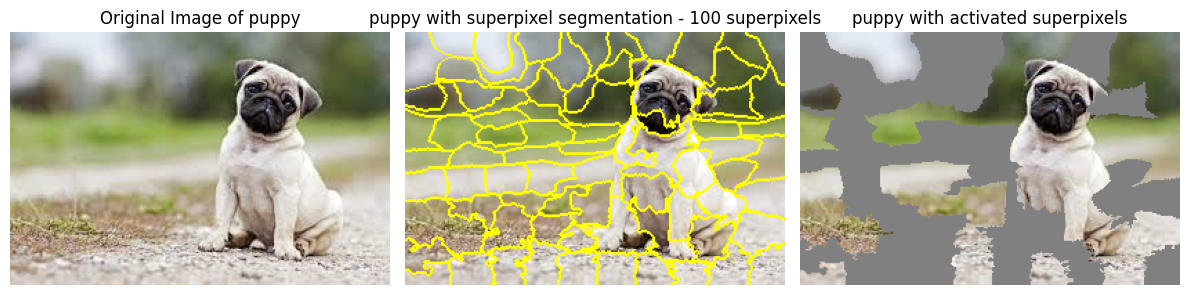

Class scores:
pug 6.001
Brabancon griffon 4.072
bull mastiff 2.875


In [ ]:
classifier2.get_classes(image_paths[1])

In [ ]:
classifier2.generate_local_dataset()

100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


In [ ]:
classifier2.df

,class,score,interpretable_instance,kernel_similarity,perturbation_score,loss
0,pug,6.000716,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.947059,3.917324,4.110735
1,pug,6.000716,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",0.949255,5.420984,0.319035
2,pug,6.000716,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.946779,4.927768,1.089950
3,pug,6.000716,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.954562,5.039085,0.882716
4,pug,6.000716,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.934480,5.508824,0.226105
...,...,...,...,...,...,...
595,bull mastiff,2.874505,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.939967,1.591972,1.546141
596,bull mastiff,2.874505,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.946853,2.154046,0.491474
597,bull mastiff,2.874505,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.939254,3.490134,0.355976
598,bull mastiff,2.874505,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.946501,3.206376,0.104246


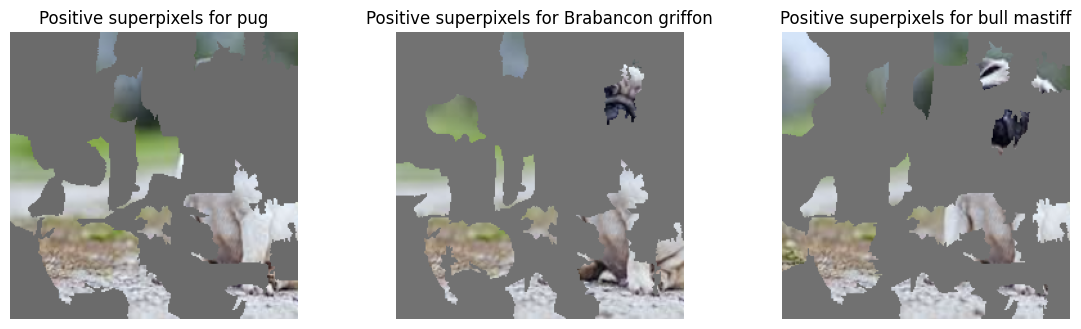

In [ ]:
classifier2.process_image()

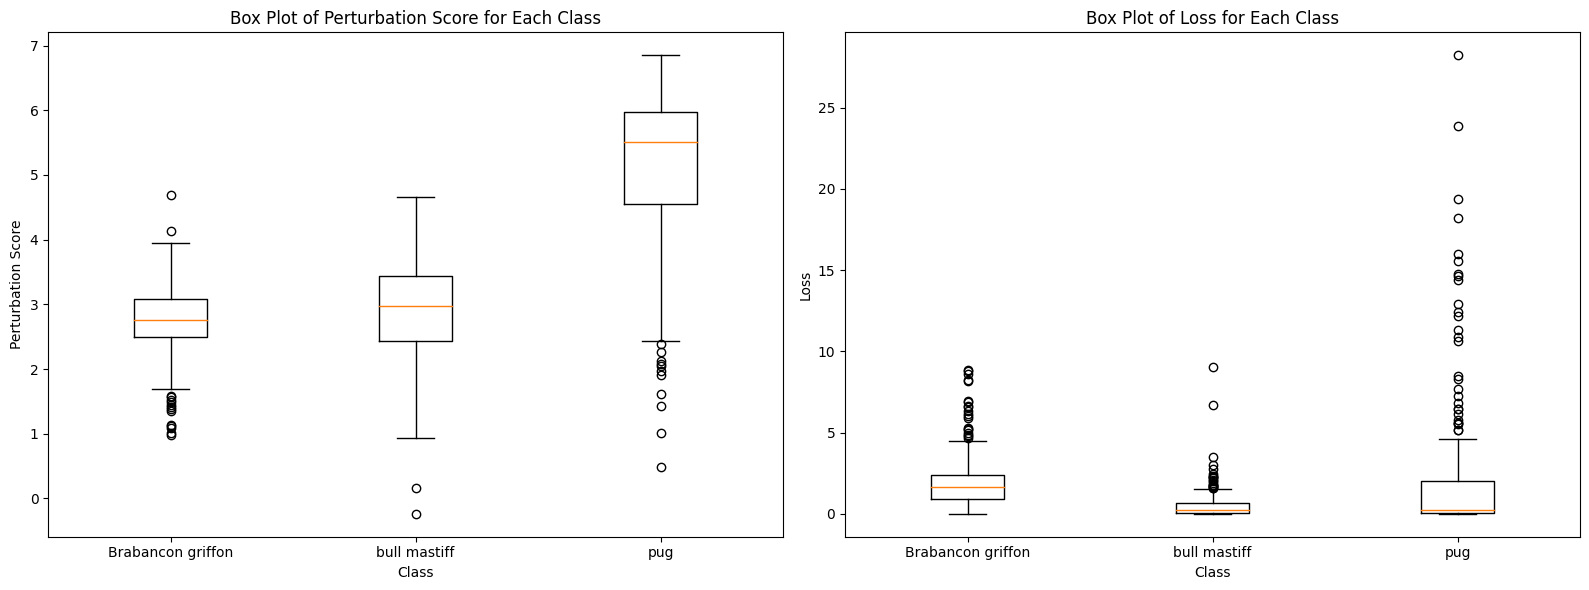

In [ ]:
classifier2.plot_boxplots()

## Image 3

In [ ]:
classifier3 = ImageClassifier()

In [ ]:
classifier3.initialize()

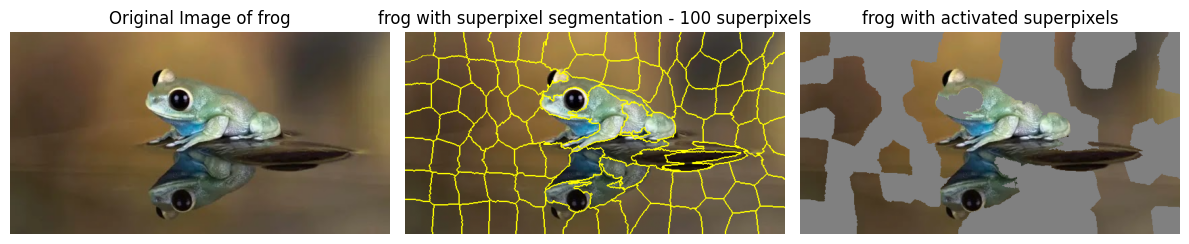

Class scores:
tailed frog 6.318
tree frog 6.177
bullfrog 2.477


In [ ]:
classifier3.get_classes(image_paths[2])

In [ ]:
classifier3.generate_local_dataset()

100%|██████████| 200/200 [00:39<00:00,  5.07it/s]


In [ ]:
classifier3.df

,class,score,interpretable_instance,kernel_similarity,perturbation_score,loss
0,tailed frog,6.317719,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.981598,2.686670,12.941892
1,tailed frog,6.317719,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.980763,5.776578,0.287200
2,tailed frog,6.317719,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.969711,3.748696,6.399976
3,tailed frog,6.317719,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.981437,2.554200,13.901150
4,tailed frog,6.317719,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.973249,4.762385,2.354351
...,...,...,...,...,...,...
595,bullfrog,2.477131,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",0.980558,2.629260,0.022693
596,bullfrog,2.477131,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.970113,0.608810,3.386302
597,bullfrog,2.477131,"[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.980980,0.991397,2.165419
598,bullfrog,2.477131,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.970558,1.047643,1.983275


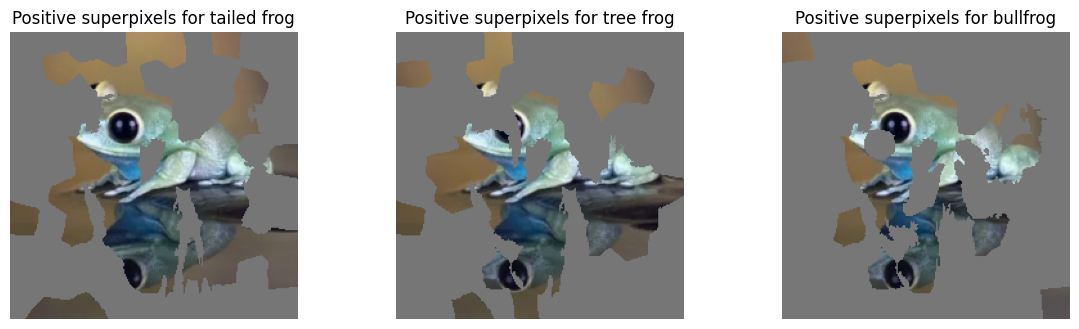

In [ ]:
classifier3.process_image()

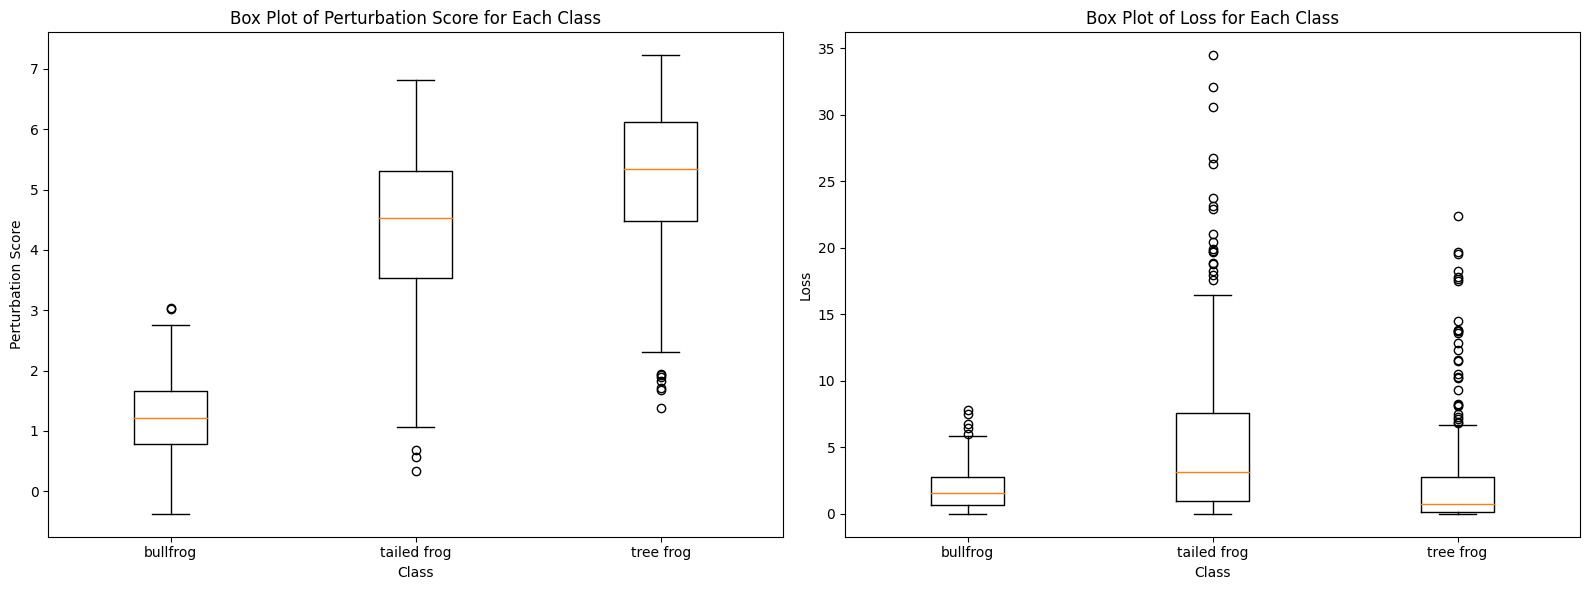

In [ ]:
classifier3.plot_boxplots()